In [1]:
import os
import gc
import math
import random
from collections import defaultdict

import pandas as pd
import numpy as np
import sys
import kagglehub
from pathlib import Path

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torch.optim import Adam
from tqdm import tqdm_notebook as tqdm

from sklearn.metrics import classification_report, f1_score

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# 1. Environment diagnostics
if 'google.colab' in sys.modules:
    print("➡️ Running in Colab")
else:
    print("➡️ Running in local Python / VS Code")


# 2. Downloading the dataset via kagglehub
path = kagglehub.dataset_download("alaakhaled/conll003-englishversion")
path = Path(path)

print("Path to dataset files:", path)  

print("Dataset root:", path)

➡️ Running in Colab
Using Colab cache for faster access to the 'conll003-englishversion' dataset.
Path to dataset files: /kaggle/input/conll003-englishversion
Dataset root: /kaggle/input/conll003-englishversion


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def load_sentences(filepath):
    final = []
    sentences = []

    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()

            if line == "" or line.startswith("-DOCSTART-"):
                if sentences:
                    final.append(sentences)
                    sentences = []
                continue

            parts = line.split()          # <- важливо
            token = parts[0]
            ner_tag = parts[-1]           # <- найнадійніше: остання колонка
            sentences.append((token, ner_tag))

    if sentences:                         # <- щоб не втратити останнє речення
        final.append(sentences)

    return final

  


In [5]:
train_sents = load_sentences(path / 'train.txt')
test_sents = load_sentences(path / 'test.txt')
val_sents = load_sentences(path / 'valid.txt')

In [6]:
print("Кількість речень:", len(train_sents))
print("Довжина першого речення (кількість токенів):", len(train_sents[0]))
print("Перші 10 токенів першого речення:", train_sents[0][:10])

Кількість речень: 14041
Довжина першого речення (кількість токенів): 9
Перші 10 токенів першого речення: [('EU', 'B-ORG'), ('rejects', 'O'), ('German', 'B-MISC'), ('call', 'O'), ('to', 'O'), ('boycott', 'O'), ('British', 'B-MISC'), ('lamb', 'O'), ('.', 'O')]


In [7]:
tags = sorted({tag for sent in train_sents for _, tag in sent})
print("Унікальні NER-теги:", tags)

Унікальні NER-теги: ['B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


In [8]:
ner_labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
id2label = {str(i): label for i, label in enumerate(ner_labels)}
# label2id = {value: int(key) for key, value in id2label.items()}

label2id = {label: i for i, label in enumerate(ner_labels)}

In [9]:
def get_df(samples):
    df,label = [], []
    for lines in samples:
        cur_line, cur_label = list(zip(*lines))
        df.append(list(cur_line))
        label.append([label2id[i] for i in cur_label])
    return {'text':df, 'label':label}
    
    
train_df = get_df(train_sents)
test_df = get_df(test_sents)
val_df = get_df(val_sents)
print("Приклад з тренувального набору:")
print(train_df['text'][0])
print(train_df['label'][0])

Приклад з тренувального набору:
['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
[3, 0, 7, 0, 0, 0, 7, 0, 0]


In [10]:
word_dict = defaultdict(int)
for line in train_df['text']:
    for word in line:
        word_dict[word] += 1

In [11]:
lower_freq_word = []
for word, freq in word_dict.items():
    if freq < 2:
        lower_freq_word.append(word)
# print(lower_freq_word)

for word in lower_freq_word:
    del word_dict[word]

In [12]:
word2id = {'<PAD>': 0, '<UNK>': 1}

for word in word_dict.keys():
    if word not in word2id:
        word2id[word] = len(word2id)

In [13]:
def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w in to_ix.keys():
            idxs.append(to_ix[w])
        else:
            idxs.append(to_ix['<UNK>'])
    return idxs


In [14]:
class CoNLLDataset(Dataset):
    def __init__(self, df):
        self.texts = df['text']
        self.labels = df['label']

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        inputs = prepare_sequence(self.texts[item], word2id)
        label = self.labels[item]
        return {
            'input_ids': inputs,
            'labels': label
        }

In [15]:
class Collate:
    def __init__(self, train):
        self.train = train

    def __call__(self, batch):
        output = dict()
        output["input_ids"] = [sample["input_ids"] for sample in batch]
        if self.train:
            output["labels"] = [sample["labels"] for sample in batch]

        # calculate max token length of this batch
        batch_max = max([len(ids) for ids in output["input_ids"]])

        # add padding

        output["input_ids"] = [s + (batch_max - len(s)) * [word2id['<PAD>']] for s in output["input_ids"]]
        if self.train:
            output['labels'] = [s + (batch_max - len(s)) * [-100] for s in output["labels"]]

        # convert to tensors
        output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)
        if self.train:
            output["labels"] = torch.tensor(output["labels"], dtype=torch.long)

        return output
    
collate_fn = Collate(True)


In [16]:
class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=3, batch_first=True)

        # 3. Dense Layer
        self.fc = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text):

        embeddings = self.embeddings(batch_text)
        
        lstm_output, _ = self.lstm(embeddings) 

        logits = self.fc(lstm_output)
        return logits


In [17]:
def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 0:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask


In [18]:
def train(model, train_loader, val_loader, batch_size, max_epochs, num_batches, patience, output_path):
    criterion = nn.CrossEntropyLoss(ignore_index=-100)  # we mask the <pad> labels
    optimizer = Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        model.train()
        for batch in tqdm(train_loader, total=num_batches, desc=f"Epoch {epoch}"):
            
            cur_batch_size, text_length = batch['input_ids'].shape
            
            pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch['labels'].to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_score = f1_score(correct, predictions, average="macro")
        train_f_score_history.append(train_score)
            
        print("Total training loss:", total_loss)
        print("Training Macro F1:", train_score)
        
        total_loss = 0
        predictions, correct = [], []
        
        model.eval()
        with torch.no_grad():
            for batch in val_loader:

                cur_batch_size, text_length = batch['input_ids'].shape
                
                pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
                gold = batch['labels'].to(device).view(cur_batch_size*text_length)
                
                loss = criterion(pred, gold)
                total_loss += loss.item()

                _, pred_indices = torch.max(pred, 1)
                predicted_labels = list(pred_indices.cpu().numpy())
                correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())

                predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                       correct_labels)

                predictions += predicted_labels
                correct += correct_labels

        dev_score = f1_score(correct, predictions, average="macro")
            
        print("Total validation loss:", total_loss)
        print("Validation Macro F1:", dev_score)
        
        dev_f = dev_score
        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Validation F-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history


In [19]:
def test(model, test_iter, batch_size, labels, target_names): 
    total_loss = 0
    predictions, correct = [], []
    
    model.eval()
    with torch.no_grad():    
    
        for batch in test_iter:

            cur_batch_size, text_length = batch['input_ids'].shape

            pred = model(batch['input_ids'].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch['labels'].to(device).view(cur_batch_size*text_length)

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch['labels'].view(cur_batch_size*text_length).numpy())

            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)

            predictions += predicted_labels
            correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))


In [20]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
NUM_CLASSES = len(id2label)
MAX_EPOCHS = 50
PATIENCE = 3
BATCH_SIZE = 32
VOCAB_SIZE = len(word2id)
OUTPUT_PATH = "/tmp/bilstmtagger"
num_batches = math.ceil(len(train_df) / BATCH_SIZE)


In [21]:
train_dataset = CoNLLDataset(train_df)
val_dataset = CoNLLDataset(val_df)
test_dataset = CoNLLDataset(test_df)

train_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=False)

val_loader = DataLoader(val_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=False)

test_loader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=collate_fn,
                              num_workers=4,
                              pin_memory=True,
                              drop_last=False)


In [22]:
tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES) 
tagger


BiLSTMTagger(
  (embeddings): Embedding(11986, 100)
  (lstm): LSTM(100, 64, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=9, bias=True)
)

In [23]:
train_f, dev_f = train(tagger.to(device), train_loader, val_loader, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 337.1172842234373
Training Macro F1: 0.02956129789126642
Total validation loss: 53.19447872042656
Validation Macro F1: 0.1499292863178289
Saving model.


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 165.2171627022326
Training Macro F1: 0.33777267001337796
Total validation loss: 29.98122552782297
Validation Macro F1: 0.3849688593362559
Saving model.


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 92.25136318523437
Training Macro F1: 0.5789470467751953
Total validation loss: 22.511571334674954
Validation Macro F1: 0.6221085389371255
Saving model.


Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 55.63243897771463
Training Macro F1: 0.7066876304762684
Total validation loss: 19.36593888979405
Validation Macro F1: 0.6766265438704749
Saving model.


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 36.07038911036216
Training Macro F1: 0.77422190467302
Total validation loss: 17.63049938553013
Validation Macro F1: 0.7020934495693297
Saving model.


Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 24.355213755276054
Training Macro F1: 0.8173111423302808
Total validation loss: 18.127525668242015
Validation Macro F1: 0.7061879454371116
Saving model.


Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 17.886218321160413
Training Macro F1: 0.8402320390655591
Total validation loss: 18.110464528261218
Validation Macro F1: 0.7160264097554514
Saving model.


Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 14.028825382119976
Training Macro F1: 0.8497136320278147
Total validation loss: 18.456601500947727
Validation Macro F1: 0.7238818400004587
Saving model.


Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 10.58964775694767
Training Macro F1: 0.8611399806675988
Total validation loss: 19.215535681170877
Validation Macro F1: 0.720778497373906


Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 8.845666608423926
Training Macro F1: 0.8660189442096905
Total validation loss: 19.765053448849358
Validation Macro F1: 0.7260168796225517
Saving model.


Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 6.8056539782410255
Training Macro F1: 0.871310901852491
Total validation loss: 20.65951136991498
Validation Macro F1: 0.72422968011131


Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 5.794700173806632
Training Macro F1: 0.8749953610841855
Total validation loss: 20.951464637662866
Validation Macro F1: 0.7306194851067292
Saving model.


Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 4.543473443067342
Training Macro F1: 0.8782941749890107
Total validation loss: 21.79143355070846
Validation Macro F1: 0.7308307597770863
Saving model.


Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 4.371717219459242
Training Macro F1: 0.8775149610115385
Total validation loss: 22.80236526252702
Validation Macro F1: 0.7289778378037997


Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 4.57748717868526
Training Macro F1: 0.8779349014454362
Total validation loss: 22.611961160160718
Validation Macro F1: 0.7290534124889604


Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 3.3395001451062853
Training Macro F1: 0.881257433511263
Total validation loss: 23.510335000537452
Validation Macro F1: 0.7346710836961213
Saving model.


Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 2.4993298390254495
Training Macro F1: 0.8825317022978234
Total validation loss: 25.021088115703606
Validation Macro F1: 0.7335707685954853


Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 2.034709651485173
Training Macro F1: 0.8843262170335774
Total validation loss: 26.48779516250943
Validation Macro F1: 0.7270166707217259


Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 1.6700616179259669
Training Macro F1: 0.8856647418560242
Total validation loss: 27.276599118311424
Validation Macro F1: 0.7249687068316748


Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s]

Total training loss: 2.6310729592078133
Training Macro F1: 0.8813769813187423
Total validation loss: 26.110203554766485
Validation Macro F1: 0.7274054693507003
Validation F-score does not improve anymore. Stop training.


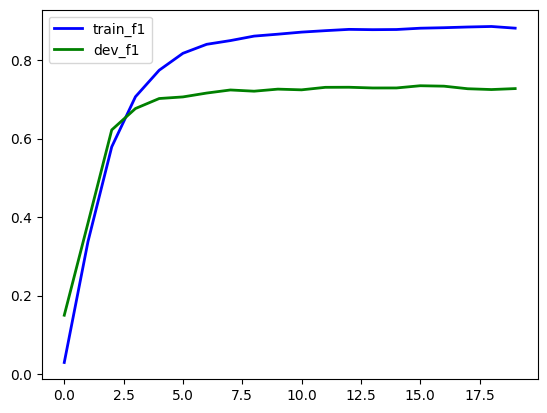

In [24]:
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f1': train_f, 
                   'dev_f1': dev_f})

plt.plot('epochs', 'train_f1', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'dev_f1', data=df, color='green', linewidth=2)
plt.legend()
plt.show()


In [25]:
tagger = torch.load(OUTPUT_PATH)

labels = list(label2id.keys())[1:]
label_idxs = list(label2id.values())[1:]

test(tagger, test_loader, BATCH_SIZE, labels = label_idxs, target_names = labels)


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.BiLSTMTagger was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.BiLSTMTagger])` or the `torch.serialization.safe_globals([__main__.BiLSTMTagger])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.